# Análise Exploratória dos Dados - Competição "Talking Data"
## Alunos: Alessandro Rivello e Raul Guarini

Fazemos uma análise dos dados de teste e treinamento neste notebook. No caso do dados de treinamento, trabalhamos com uma amostra de 10% dos dados originais, frente ao tamanho do arquivo train.csv (quase 190 milhões de linhas!!!!!). O algoritmo para escolha da amostra está disponível no script ```row_select.py```.

Ambos datasets continham a coluna "click_time" com o timestamp do acesso no formato "YYYY-MM-DD hh:mm:ss". Para poder trabalhar os dados, utilizamos o comando ```sed``` no Terminal para:
1. Eliminar informação sobre o ano e o mês, em vista do fato de que todos os dados se encontram numa janela de apenas quatro dias. Isto torna o dataset mais leve e mais fácil de ser manipulado;
2. Colocar as colunas de dias, horas, minutos e segundos separadamente, facilitando também a análise.

No caso dos dados de teste, por exemplo, o comando utilizado foi: 
```
cat test.csv | sed 's/2017-11-//g' | sed -E -e 's/[[:space:]]/,/g' -e 's/:/,/g' -e 's/click_time/days,hours,minutes,seconds/g' > test_timed.csv

```

Também julgamos desnecessária a coluna "attributed_time". É um timestamp do horário em que o download foi feito. Como veremos, ela aporta pouca informação pois o dataset é amplamente desbalanceado, com muito poucos downloads afetivos. Além disso, este dado é gerado após o download ser feito, o que o torna incompatível com a tarefa de prever se o download ocorrerá ou não. Portanto, os dados utilizados estão disponíveis nos arquivos ```10_train_timed.csv``` e ```test_timed.csv```.

In [1]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

path_raul = '/Users/Raul/Desktop/'

In [2]:
# Definir os datatypes antes da importação otimiza o uso de memória pelo Pandas.
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'days'          : 'uint8',
        'hours'         : 'uint8',
        'minutes'       : 'uint8',
        'seconds'       : 'uint8',
        }

In [3]:
# Forçando o Pandas a ler as mesmas colunas, sem necessidade de ler click_time e nem click_id na análise exploratória.
cols_train = ['ip', 'app', 'device', 'os', 'channel', 'is_attributed', 'days', 'hours', 'minutes', 'seconds']
cols_test = ['ip', 'app', 'device', 'os', 'channel', 'days', 'hours', 'minutes', 'seconds']

In [4]:
train = pd.read_csv(path_raul + '10_train_timed.csv', dtype = dtypes, usecols = cols_train)
test = pd.read_csv(path_raul + 'test_timed.csv', dtype = dtypes, usecols = cols_test)

In [5]:
train.head()

,ip,app,device,os,channel,is_attributed,days,hours,minutes,seconds
0,103022,3,1,23,379,0,6,14,37,44
1,1114221,3,1,19,379,0,6,14,37,59
2,247902,3,1,17,379,0,6,14,48,7
3,323550,3,1,13,379,0,6,14,53,39
4,484644,3,1,19,379,0,6,14,56,49


In [6]:
test.head()

,ip,app,device,os,channel,days,hours,minutes,seconds
0,5744,9,1,3,107,10,4,0,0
1,119901,9,1,3,466,10,4,0,0
2,72287,21,1,19,128,10,4,0,0
3,78477,15,1,13,111,10,4,0,0
4,123080,12,1,13,328,10,4,0,0


Vamos utilizar dados de timestamp primeiramente para entender o aspecto temporal dos dados. O quão dispersos ao longo dos dias são os cliques?

In [7]:
day_hour_train = train[['days', 'hours']].drop_duplicates().groupby('days').count()
day_hour_test = test[['days', 'hours']].drop_duplicates().groupby('days').count()

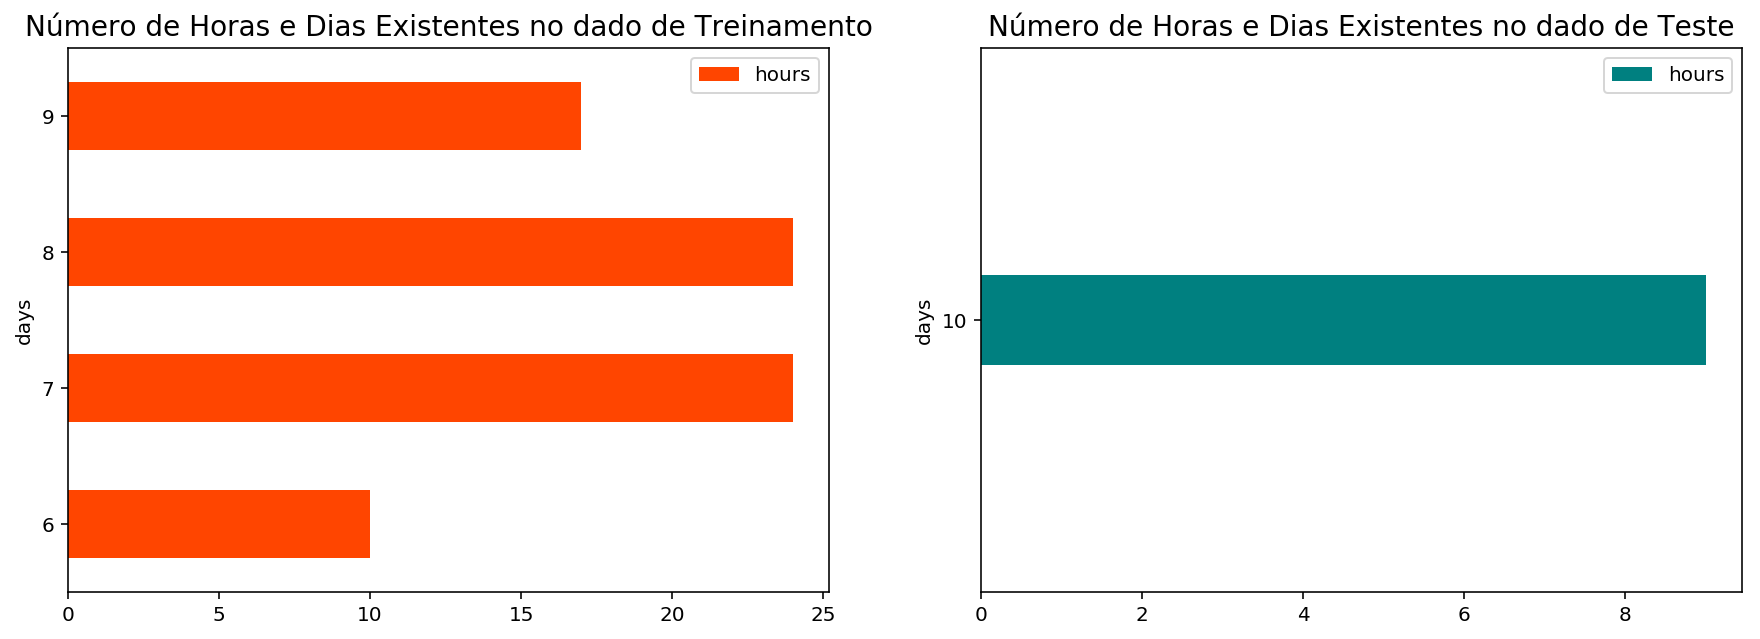

In [10]:
# Plotando os resultados acima
fig, (axs) = plt.subplots(1,2,figsize=(15,5))
day_hour_train.plot(kind = 'barh', ax = axs[0], title = 'Número de Horas e Dias Existentes no dado de Treinamento', color = 'orangered', width=0.5);
day_hour_test.plot(kind = 'barh', ax = axs[1], title = 'Número de Horas e Dias Existentes no dado de Teste', color = 'teal', width=0.1,);
axs[0].title.set_size(14)
axs[1].title.set_size(14)

Vemos que os dados de treinamento compreendem os dias 6,7,8 e 9, ao passo que os dados de teste são somente do dia 10. Para os dias 7 e 8, temos observações em todas as horas. Para os dados de teste, temos observações em apenas 9 horas ao longo do dia.